In [1]:
import sys
import random
from pathlib import Path

import torch
import torchaudio
import torchvision.transforms as T

import matplotlib.pyplot as plt

sys.path.append('..')
from ar.metrics import accuracy, top_5_accuracy
from ar.utils.engine import train_one_epoch, evaluate

ModuleNotFoundError: No module named 'torchaudio'

In [5]:
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html


ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


In [2]:
!mkdir -p ../data/speech_command

The syntax of the command is incorrect.


In [3]:
ds = torchaudio.datasets.SPEECHCOMMANDS('../data/speech_command', download=True)

In [4]:
classes = Path('../data/speech_command/SpeechCommands/speech_commands_v0.02')
classes = [p.stem for p in classes.iterdir()]
class2idx = {c: i for i, c in enumerate(classes)}

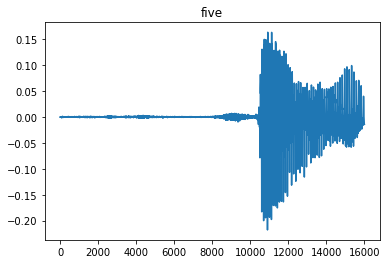

In [5]:
waveform, sample_rate, label, *_ = ds[random.randint(0, len(ds))]
plt.title(label)
plt.plot(waveform[0].numpy());

In [6]:
from IPython.display import Audio
Audio(waveform.numpy(), rate=sample_rate, autoplay=True)

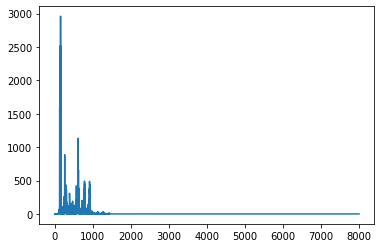

In [7]:
fft = torch.rfft(waveform, signal_ndim=1)
fft = fft[..., 0].pow(2) + fft[..., 0].pow(2)
plt.plot(fft[0]);

## MelSpectrogram from scratch

Apply a Short Time Fourier Transform to our signal with a Hanning Window.

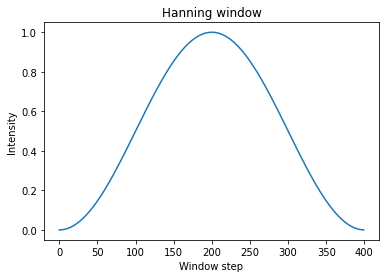

In [8]:
plt.title('Hanning window')
plt.plot(torch.hann_window(400))
plt.xlabel('Window step')
plt.ylabel('Intensity')
plt.show()

In [9]:
window_len = 400
hop_len = 160

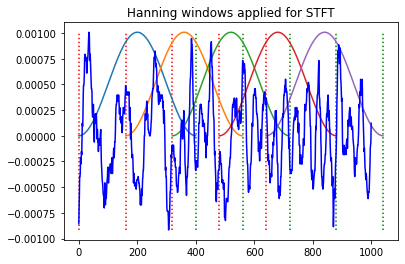

In [10]:
sample_wf = waveform.squeeze()[6000:7000]

plt.title('Hanning windows applied for STFT')
for i in range((sample_wf.size(0) // hop_len) - 1):
    plt.plot(range(i * hop_len, (i * hop_len) + window_len), 
             torch.hann_window(window_len) * sample_wf.max())
    plt.vlines(i * hop_len, 
               sample_wf.min(), 
               sample_wf.max(),
               color='r',
               linestyles='dotted')
    plt.vlines((i * hop_len) + window_len, 
               sample_wf.min(), 
               sample_wf.max(),
               color='g',
               linestyles='dotted')


plt.plot(sample_wf, 'b')
plt.show()


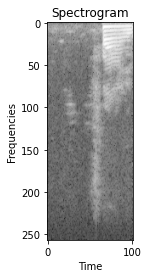

In [11]:
stft = torch.stft(waveform.squeeze(), 
                  n_fft=512, 
                  hop_length=hop_len, 
                  win_length=window_len,
                  window=torch.hann_window(400))
stft = torchaudio.functional.complex_norm(stft)

plt.title('Spectrogram')
plt.imshow(stft.log2().squeeze(), cmap='gray')
plt.xlabel('Time')
plt.ylabel('Frequencies')
plt.show()

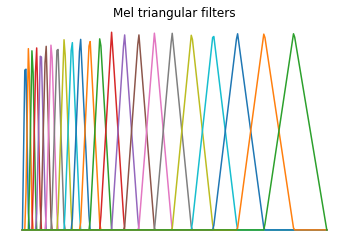

In [12]:
fbanks = torchaudio.functional.create_fb_matrix(
    stft.size(0), 
    0, sample_rate // 2, 
    23, sample_rate)

plt.title('Mel triangular filters')
plt.plot(fbanks)
plt.axis('off')
plt.show()

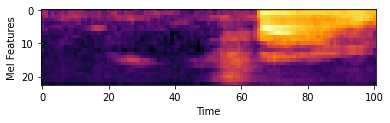

In [13]:
mel_spectogram = stft.transpose(1, 0) @ fbanks
plt.imshow(mel_spectogram.log2().t(), cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Features')
plt.show()

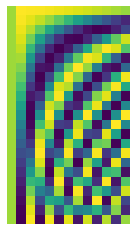

In [14]:
cosine_trans = torchaudio.functional.create_dct(13, 23, 'ortho')
plt.imshow(cosine_trans)
plt.axis('off');

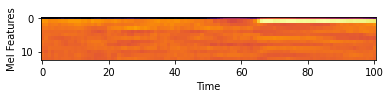

In [15]:
mfcc = (mel_spectogram + 1e-6).log() @ cosine_trans
plt.imshow(mfcc.t(), cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Features')
plt.show()

In [16]:
train_len = int(len(ds) * .9)
rand_idx = torch.randperm(len(ds))

train_ds = torch.utils.data.Subset(ds, rand_idx[:train_len])
valid_ds = torch.utils.data.Subset(ds, rand_idx[train_len:])

In [17]:
def collate_fn(batch):
    wf, sr, labels, *_ = zip(*batch)
    padded_wf = []
    
    max_len = max([o.size(1) for o in wf])
    for w in wf:
        w = w[:, :max_len]
        offset = max_len - w.size(1)
        pad_tensor = torch.zeros(1, offset)
        w = torch.cat([w, pad_tensor], dim=-1)
        padded_wf.append(w)

    wf = torch.stack(padded_wf)
    return wf, torch.as_tensor([class2idx[o] for o in labels])

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=64, collate_fn=collate_fn, pin_memory=True)

valid_dl = torch.utils.data.DataLoader(
    valid_ds, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [18]:
x, y = next(iter(train_dl))
x.size(), y.size()

(torch.Size([64, 1, 16000]), torch.Size([64]))

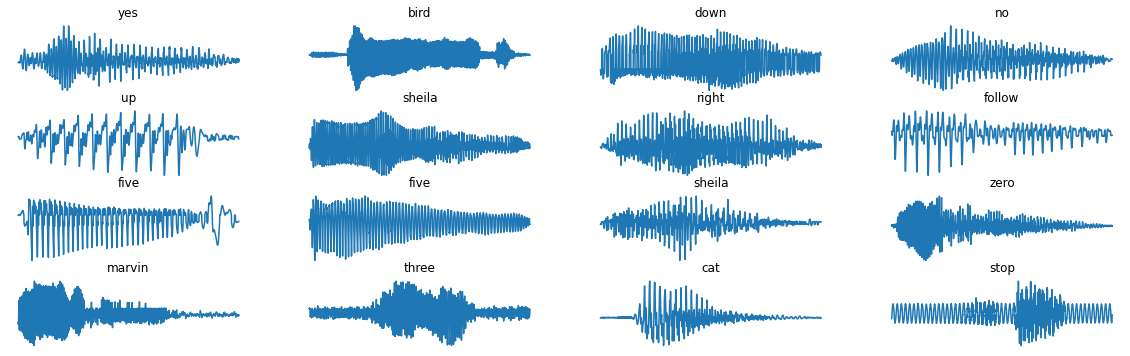

In [19]:
def show_batch(waveforms, labels):
    plt.figure(figsize=(20, 6))
    for i, (wf, l) in enumerate(zip(waveforms[:16], labels[:16])):
        plt.subplot(4, 4, i + 1)
        
        # Remove background noise and padding
        # to plot only the audio of interest
        wf = wf.squeeze().unfold(0, 20, 1).mean(-1)
        wf = wf[wf.abs() > 0.005]
        
        plt.title(classes[l.item()])
        plt.plot(wf.numpy())
        plt.axis('off')

show_batch(x, y)
plt.show()

In [22]:
device = torch.device('cuda')

model = torch.nn.Sequential(
    torchaudio.transforms.MFCC(sample_rate, 20, log_mels=True, 
                               melkwargs=dict(n_fft=512, 
                                              win_length=400, 
                                              hop_length=160)),
    torch.nn.Conv2d(1, 32, 5),
    torch.nn.Conv2d(32, 32, 3),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(32, 64, 3),
    torch.nn.Conv2d(64, 64, 3),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(inplace=True),
    torch.nn.Flatten(1),
    torch.nn.Linear(58240, 512),
    torch.nn.Dropout(.5),
    torch.nn.Linear(512, len(classes)),
    torch.nn.LogSoftmax(-1))

model.to(device)
optimzer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss()

In [23]:
for epoch in range(5):
    train_one_epoch(
        train_dl, model, optimzer, 
        loss_fn, epoch, device=device, print_freq=100)
    evaluate(valid_dl, model, loss_fn, 
             metrics=[accuracy, top_5_accuracy], device=device)


Epoch[0] [100/1489] loss: 13.642473 lr: 0.001000 time_per_step: 0.178619
Epoch[0] [200/1489] loss: 9.101631 lr: 0.001000 time_per_step: 0.135336
Epoch[0] [300/1489] loss: 7.078755 lr: 0.001000 time_per_step: 0.261674
Epoch[0] [400/1489] loss: 5.914820 lr: 0.001000 time_per_step: 0.168391
Epoch[0] [500/1489] loss: 5.156847 lr: 0.001000 time_per_step: 0.198651
Epoch[0] [600/1489] loss: 4.610806 lr: 0.001000 time_per_step: 0.109573
Epoch[0] [700/1489] loss: 4.209136 lr: 0.001000 time_per_step: 0.161991
Epoch[0] [800/1489] loss: 3.891615 lr: 0.001000 time_per_step: 0.115277
Epoch[0] [900/1489] loss: 3.627743 lr: 0.001000 time_per_step: 0.084064
Epoch[0] [1000/1489] loss: 3.403276 lr: 0.001000 time_per_step: 0.191739
Epoch[0] [1100/1489] loss: 3.210498 lr: 0.001000 time_per_step: 0.209392
Epoch[0] [1200/1489] loss: 3.042840 lr: 0.001000 time_per_step: 0.233792
Epoch[0] [1300/1489] loss: 2.896716 lr: 0.001000 time_per_step: 0.194075
Epoch[0] [1400/1489] loss: 2.766280 lr: 0.001000 time_per_s